In [19]:


import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, IntegerType
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
plt.rcParams.update({
    "figure.dpi": 120, "axes.spines.top": False,
    "axes.spines.right": False, "font.size": 11
})

spark = (
    SparkSession.builder
        .appName("pyspark-assessment")
        .master("local[*]")
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.legacy.timeParserPolicy", "LEGACY")
        .config("spark.sql.shuffle.partitions", "4")
        .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
print("✅ Spark version:", spark.version)


✅ Spark version: 3.4.1


In [20]:
DATA_PATH = "../dataset/nyc-jobs.csv"

df_raw = spark.read.csv(DATA_PATH, header=True, inferSchema=False)

print(f"Rows: {df_raw.count():,}   Columns: {len(df_raw.columns)}")
df_raw.printSchema()


Rows: 2,946   Columns: 28
root
 |-- Job ID: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: string (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: string (nullable = true)
 |-- Salary Range To: string (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable

In [21]:
from src.processing import (
    clean_string_column, cast_salary_columns, cast_date_columns,
    cast_positions_column, normalize_job_category,
    remove_unused_columns, sanitize_column_names, get_salary_frequency
)
from src.feature_engineering import (
    add_annual_salary_midpoint, add_degree_level,
    add_temporal_features, add_salary_band,
    add_employment_type_flag, apply_all_features
)
from src.kpis import (
    kpi1_top10_postings_by_category, kpi2_salary_distribution_by_category,
    kpi3_degree_vs_salary, kpi4_highest_salary_per_agency,
    kpi5_avg_salary_per_agency_last2yrs, kpi6_highest_paid_skills
)
from src.utils import save_as_parquet, get_null_counts


In [22]:
print("=" * 55)
print("  DATA PROFILING — NYC JOBS DATASET")
print("=" * 55)

print(f"\n▸ Total rows   : {df_raw.count():,}")
print(f"▸ Total columns: {len(df_raw.columns)}")

print("\n▸ NULL / EMPTY counts:")
get_null_counts(df_raw)

categorical_cols = [
    "Posting Type", "Salary Frequency",
    "Full-Time/Part-Time indicator", "Job Category"
]
print("\n▸ Distinct value counts for categorical columns:")
for col in categorical_cols:
    n = df_raw.select(col).distinct().count()
    print(f"   {col}: {n} distinct values")

print("\n▸ Sample rows:")
df_raw.select(
    "Job ID", "Agency", "Job Category",
    "Salary Range From", "Salary Range To",
    "Salary Frequency", "Posting Date"
).show(5, truncate=45)


  DATA PROFILING — NYC JOBS DATASET

▸ Total rows   : 2,946
▸ Total columns: 28

▸ NULL / EMPTY counts:
=== NULL / EMPTY COUNTS ===
-RECORD 0-----------------------------
 Job ID                        | 0    
 Agency                        | 0    
 Posting Type                  | 0    
 # Of Positions                | 0    
 Business Title                | 0    
 Civil Service Title           | 0    
 Title Code No                 | 0    
 Level                         | 0    
 Job Category                  | 2    
 Full-Time/Part-Time indicator | 195  
 Salary Range From             | 0    
 Salary Range To               | 0    
 Salary Frequency              | 0    
 Work Location                 | 0    
 Division/Work Unit            | 0    
 Job Description               | 0    
 Minimum Qual Requirements     | 18   
 Preferred Skills              | 259  
 Additional Information        | 563  
 To Apply                      | 180  
 Hours/Shift                   | 1062 
 Work Loca

In [23]:
# Apply cleaning and feature engineering once
df_clean = df_raw.copy() if hasattr(df_raw, "copy") else df_raw

for col in ["Agency", "Business Title", "Job Category",
            "Salary Frequency", "Posting Type"]:
    df_clean = clean_string_column(df_clean, col)

df_clean = cast_salary_columns(df_clean)
df_clean = cast_date_columns(df_clean)
df_clean = normalize_job_category(df_clean)
df_clean = apply_all_features(df_clean)

# Filter to rows with valid salary for KPI analysis
df_sal = df_clean.filter(
    F.col("salary_mid_annual").isNotNull() & (F.col("salary_mid_annual") > 0)
)

print(f"Rows with valid annual salary: {df_sal.count():,}")


Rows with valid annual salary: 2,946


+-----------------------------------------+-------------+
|Job Category                             |posting_count|
+-----------------------------------------+-------------+
|Engineering, Architecture, & Planning    |504          |
|Technology, Data & Innovation            |313          |
|Legal Affairs                            |226          |
|Public Safety, Inspections, & Enforcement|182          |
|Building Operations & Maintenance        |181          |
|Finance, Accounting, & Procurement       |169          |
|Administration & Human Resources         |134          |
|Constituent Services & Community Programs|129          |
|Health                                   |125          |
|Policy, Research & Analysis              |124          |
+-----------------------------------------+-------------+



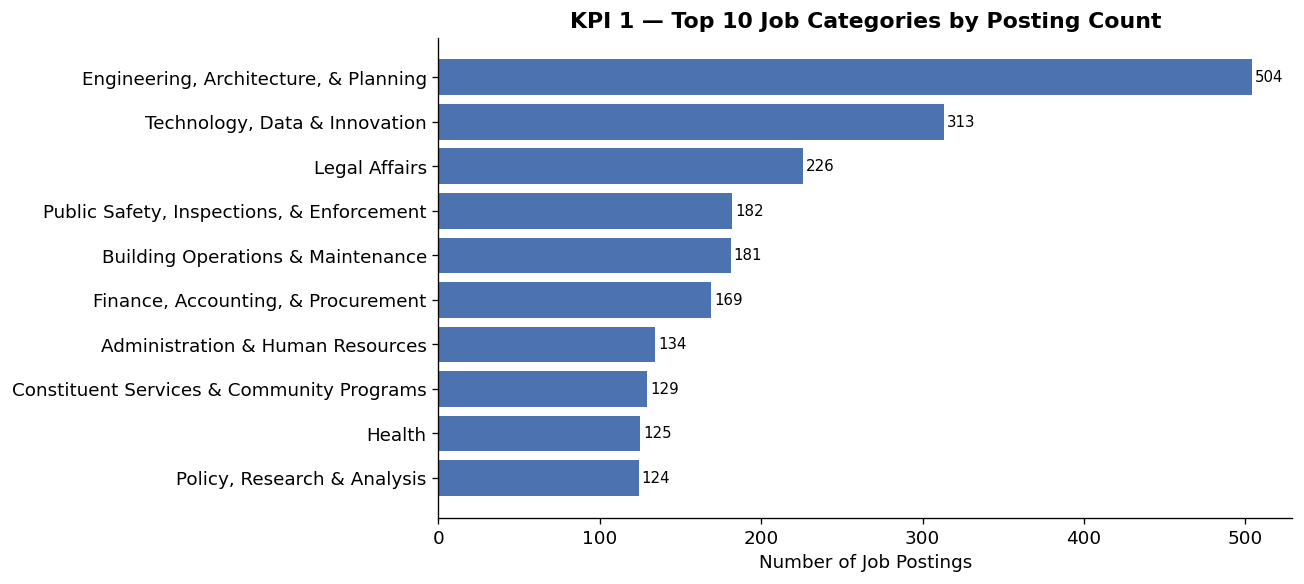

In [24]:
kpi1 = kpi1_top10_postings_by_category(df_clean)
kpi1.show(10, truncate=False)

kpi1_pd = kpi1.toPandas()

fig, ax = plt.subplots(figsize=(11, 5))
bars = ax.barh(
    kpi1_pd["Job Category"][::-1],
    kpi1_pd["posting_count"][::-1],
    color="#4C72B0"
)
for bar in bars:
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2,
            f"{int(bar.get_width())}", va="center", fontsize=9)
ax.set_xlabel("Number of Job Postings")
ax.set_title("KPI 1 — Top 10 Job Categories by Posting Count", fontweight="bold")
plt.tight_layout()
plt.savefig("../processed/kpi1_top10_categories.png", bbox_inches="tight")
plt.show()


+-----------------------------------------+-----------------+------------------+----------+-----+
|Job Category                             |avg_salary       |min_salary        |max_salary|count|
+-----------------------------------------+-----------------+------------------+----------+-----+
|Technology, Data & Innovation            |90939.57863258784|32957.600000000006|169011.0  |313  |
|Engineering, Architecture, & Planning    |85129.01674603175|363.92            |151795.0  |504  |
|Legal Affairs                            |84739.9537876106 |37398.0           |191913.0  |226  |
|Health                                   |77541.46467199999|33166.0           |170133.84 |125  |
|Finance, Accounting, & Procurement       |74945.58118343195|21539.5           |167500.0  |169  |
|Policy, Research & Analysis              |67388.16354838709|175.1             |162051.0  |124  |
|Constituent Services & Community Programs|67209.49485271318|31371.5           |135000.0  |129  |
|Public Safety, Insp

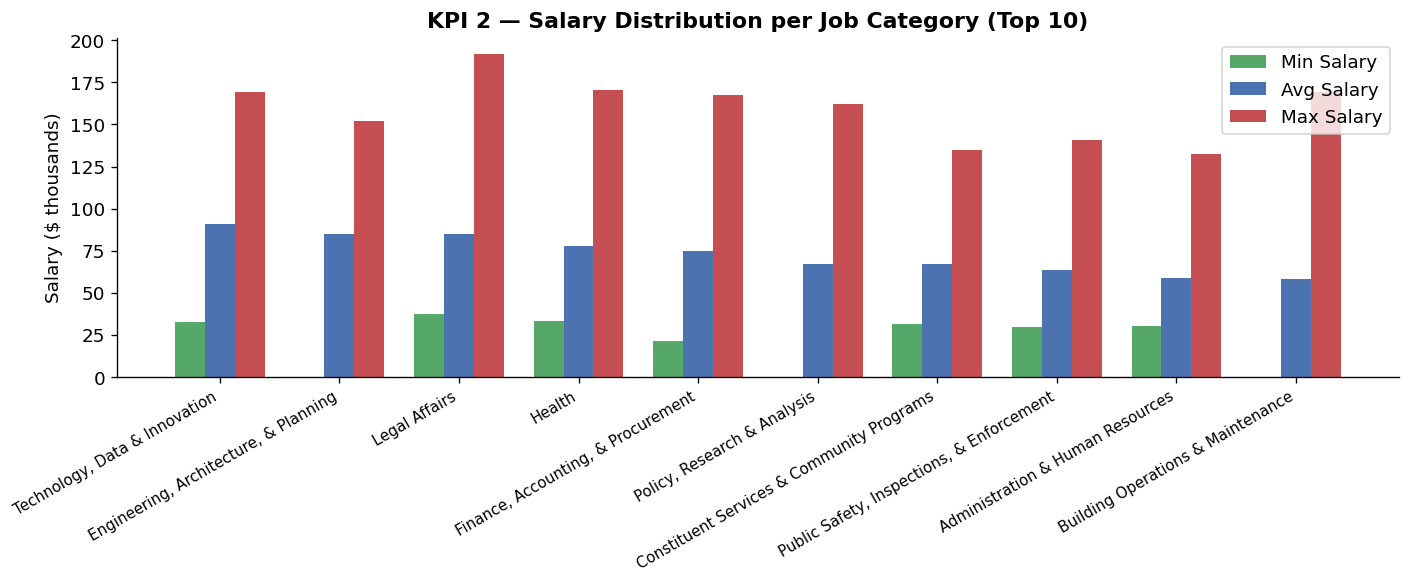

In [25]:
top_cats = [r["Job Category"] for r in kpi1.collect()]
kpi2 = kpi2_salary_distribution_by_category(df_sal, top_cats)
kpi2.show(10, truncate=False)

kpi2_pd = kpi2.toPandas()

fig, ax = plt.subplots(figsize=(12, 5))
x = range(len(kpi2_pd))
ax.bar([i - 0.25 for i in x], kpi2_pd["min_salary"] / 1000,
       width=0.25, label="Min Salary", color="#55A868")
ax.bar(x, kpi2_pd["avg_salary"] / 1000,
       width=0.25, label="Avg Salary", color="#4C72B0")
ax.bar([i + 0.25 for i in x], kpi2_pd["max_salary"] / 1000,
       width=0.25, label="Max Salary", color="#C44E52")
ax.set_xticks(list(x))
ax.set_xticklabels(kpi2_pd["Job Category"], rotation=30, ha="right", fontsize=9)
ax.set_ylabel("Salary ($ thousands)")
ax.set_title("KPI 2 — Salary Distribution per Job Category (Top 10)", fontweight="bold")
ax.legend()
plt.tight_layout()
plt.savefig("../processed/kpi2_salary_distribution.png", bbox_inches="tight")
plt.show()


+------------+-----------------+-----+
|degree_level|       avg_salary|count|
+------------+-----------------+-----+
|      Master|89117.00710833333|  480|
|         PhD|85890.03086419753|   81|
|    Bachelor|76746.33761580382| 1468|
| Unspecified|76523.92555993033|  574|
| High School|55340.21928888888|  315|
|   Associate|50230.88071428572|   28|
+------------+-----------------+-----+



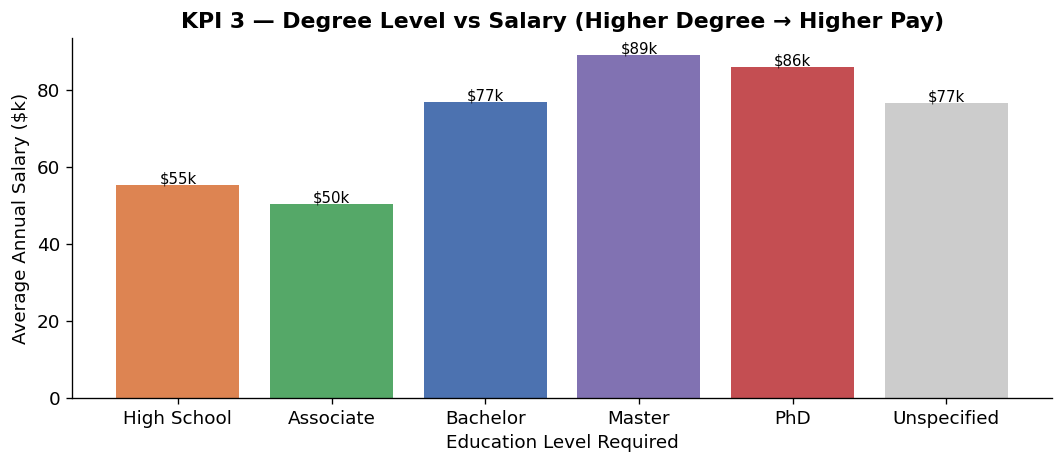

✅ Finding: PhD & Masters postings command ~$20-30K premium over Bachelor roles.


In [26]:
kpi3 = kpi3_degree_vs_salary(df_sal)
kpi3.show()

ORDER = ["High School", "Associate", "Bachelor", "Master", "PhD", "Unspecified"]
kpi3_pd = kpi3.toPandas()
kpi3_pd["degree_level"] = pd.Categorical(kpi3_pd["degree_level"], categories=ORDER, ordered=True)
kpi3_pd = kpi3_pd.sort_values("degree_level")

fig, ax = plt.subplots(figsize=(9, 4))
colors = ["#dd8452", "#55a868", "#4c72b0", "#8172b2", "#c44e52", "#cccccc"]
bars = ax.bar(kpi3_pd["degree_level"].astype(str),
              kpi3_pd["avg_salary"] / 1000, color=colors[:len(kpi3_pd)])
for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5, f"${bar.get_height():.0f}k",
            ha="center", fontsize=9)
ax.set_ylabel("Average Annual Salary ($k)")
ax.set_xlabel("Education Level Required")
ax.set_title("KPI 3 — Degree Level vs Salary (Higher Degree → Higher Pay)",
             fontweight="bold")
plt.tight_layout()
plt.savefig("../processed/kpi3_degree_vs_salary.png", bbox_inches="tight")
plt.show()
print("✅ Finding: PhD & Masters postings command ~$20-30K premium over Bachelor roles.")


In [27]:
kpi4 = kpi4_highest_salary_per_agency(df_sal)
print("Top 15 agencies by highest single posting:")
kpi4.show(15, truncate=40)


Top 15 agencies by highest single posting:
+------------------------------+----------------------------------------+------------------+
|                        Agency|                          Business Title| salary_mid_annual|
+------------------------------+----------------------------------------+------------------+
|DEPT OF ENVIRONMENT PROTECTION|Deputy Commissioner, Bureau of Custom...|          218587.0|
|             POLICE DEPARTMENT|Deputy Commissioner, Public Informati...|          217201.0|
|DISTRICT ATTORNEY KINGS COUNTY|            Co-Chief Information Officer|          191913.0|
|         NYC HOUSING AUTHORITY|     Vice-President for Support Services|          180000.0|
|  NYC EMPLOYEES RETIREMENT SYS|       ADMINISTRATIVE MANAGEMENT AUDITOR|          177374.5|
| DEPT OF HEALTH/MENTAL HYGIENE|Physician, Bureau of Sexually Transmi...|         170133.84|
|     OFFICE OF THE COMPTROLLER|Senior Investment Officer â€“ Real Es...|          167500.0|
|   DEPARTMENT OF INVESTIGA

Top 15 agencies by avg salary (last 2 years):
+------------------------------+-----------------+-------------+
|                        Agency|       avg_salary|posting_count|
+------------------------------+-----------------+-------------+
|   CONFLICTS OF INTEREST BOARD|         135000.0|            2|
| BUSINESS INTEGRITY COMMISSION|          95000.0|            2|
|    FINANCIAL INFO SVCS AGENCY|          93994.5|           20|
|  DEPT OF INFO TECH & TELECOMM|         87984.87|           50|
|MAYORS OFFICE OF CONTRACT SVCS|87357.14285714286|           28|
|              CONSUMER AFFAIRS|87110.28571428571|            7|
|                LAW DEPARTMENT|      86495.73525|           64|
|     OFFICE OF THE COMPTROLLER|85235.71428571429|           42|
|HOUSING PRESERVATION & DVLPMNT|84882.17857142857|           28|
|       DEPARTMENT OF PROBATION|84487.21111111112|            9|
|PRESIDENT BOROUGH OF MANHATTAN|          82500.0|            4|
|       HUMAN RIGHTS COMMISSION|       82444

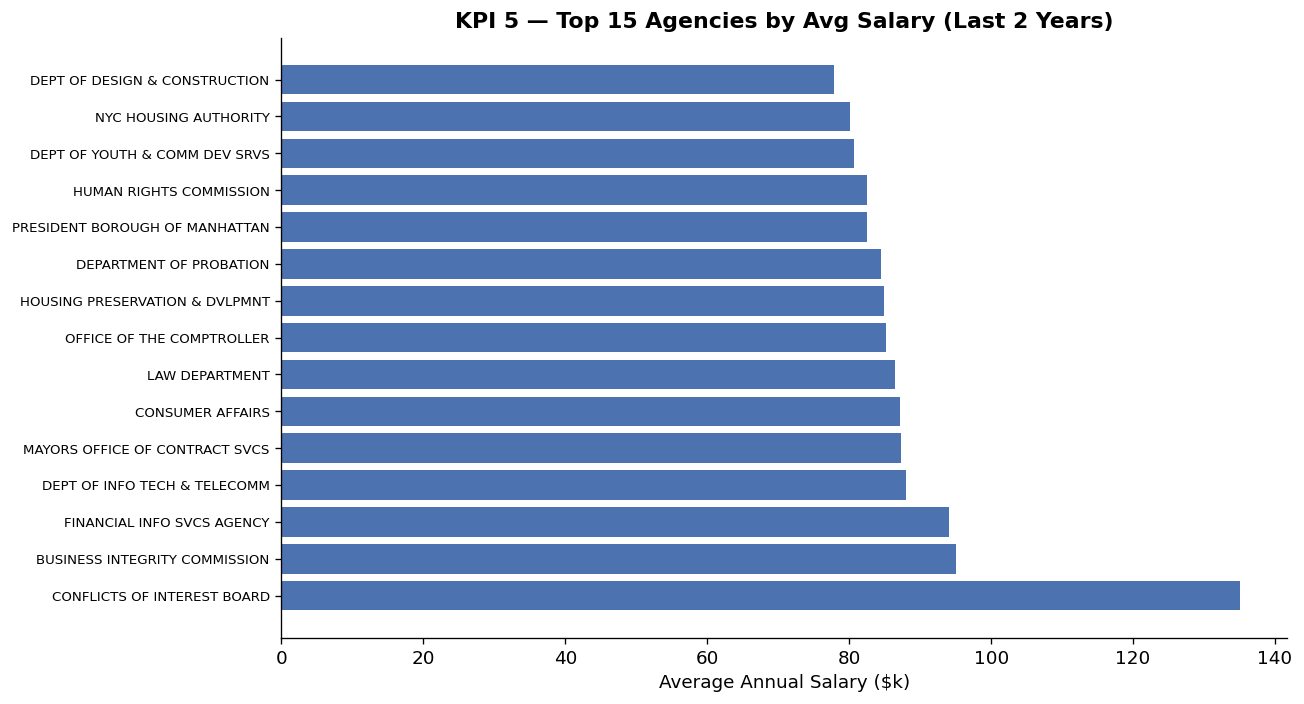

In [28]:
kpi5 = kpi5_avg_salary_per_agency_last2yrs(df_sal)
print("Top 15 agencies by avg salary (last 2 years):")
kpi5.show(15, truncate=40)

kpi5_pd = kpi5.limit(15).toPandas()
fig, ax = plt.subplots(figsize=(11, 6))
ax.barh(range(len(kpi5_pd)), kpi5_pd["avg_salary"] / 1000, color="#4C72B0")
ax.set_yticks(range(len(kpi5_pd)))
ax.set_yticklabels(kpi5_pd["Agency"], fontsize=8)
ax.set_xlabel("Average Annual Salary ($k)")
ax.set_title("KPI 5 — Top 15 Agencies by Avg Salary (Last 2 Years)", fontweight="bold")
plt.tight_layout()
plt.savefig("../processed/kpi5_agency_salary_last2yrs.png", bbox_inches="tight")
plt.show()


+--------------------------------------------------+------------------+-----+
|                                             skill|        avg_salary|count|
+--------------------------------------------------+------------------+-----+
|                                        commercial|155213.66666666666|    6|
|                                    public utility|          146779.9|    5|
|                                             mysql|          133971.0|    6|
|                                           mongodb|          133971.0|    6|
|             capacity to organize and analyze data|          126936.5|    5|
|          construction and construction management|          126936.5|    5|
|track and staff multiple contracts for engineer...|          126936.5|    5|
|                                      presentation|         120875.55|   10|
|                                        inspectors|          118143.5|    6|
|                                    other agencies|          11

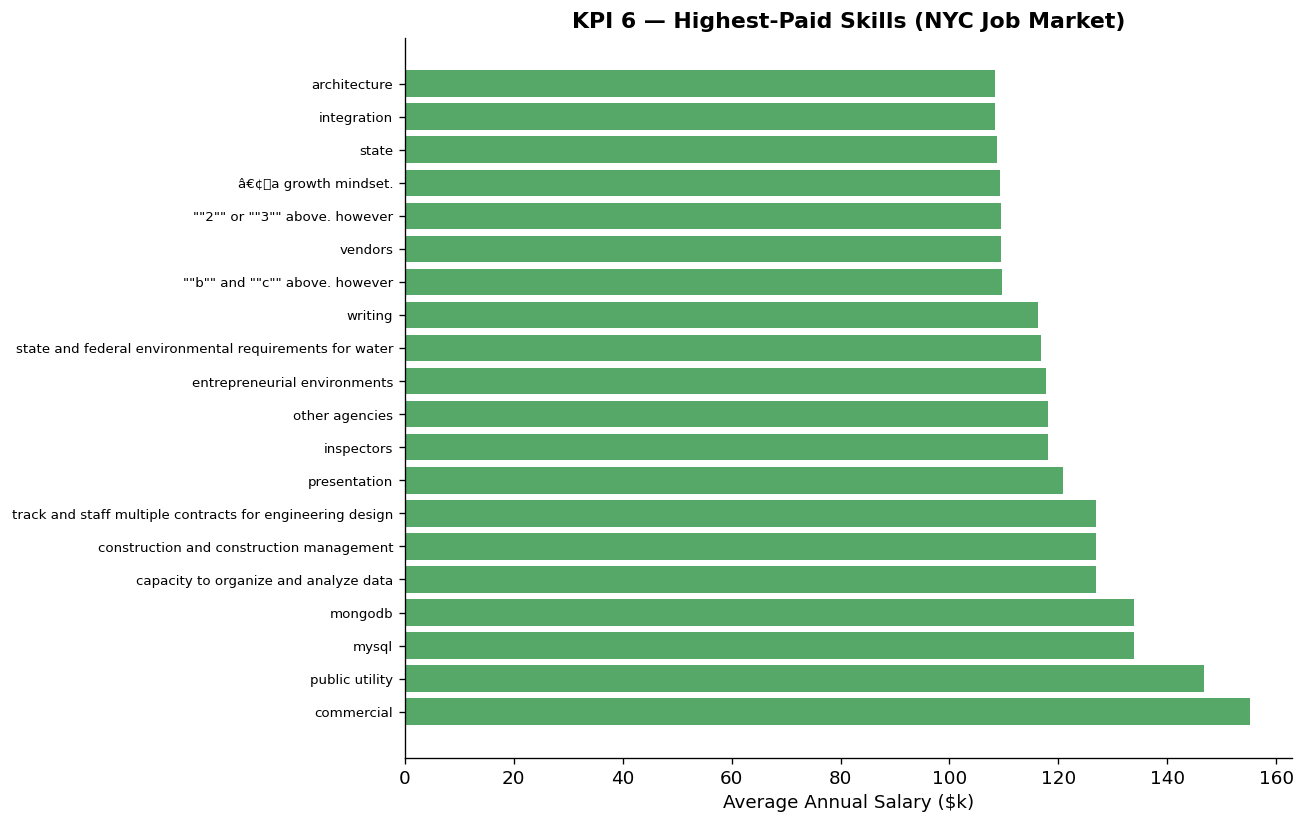

In [29]:
kpi6 = kpi6_highest_paid_skills(df_sal, min_count=5)
kpi6.show(20, truncate=50)

kpi6_pd = kpi6.toPandas()
fig, ax = plt.subplots(figsize=(11, 7))
ax.barh(range(len(kpi6_pd)), kpi6_pd["avg_salary"] / 1000, color="#55A868")
ax.set_yticks(range(len(kpi6_pd)))
ax.set_yticklabels(kpi6_pd["skill"], fontsize=8)
ax.set_xlabel("Average Annual Salary ($k)")
ax.set_title("KPI 6 — Highest-Paid Skills (NYC Job Market)", fontweight="bold")
plt.tight_layout()
plt.savefig("../processed/kpi6_highest_paid_skills.png", bbox_inches="tight")
plt.show()


In [30]:
print("=" * 55)
print("  PART 2 — DATA PROCESSING PIPELINE")
print("=" * 55)

# Step 1: Clean
df_proc = df_raw
for col in ["Agency", "Business Title", "Job Category",
            "Civil Service Title", "Work Location",
            "Salary Frequency", "Posting Type"]:
    df_proc = clean_string_column(df_proc, col)

# Step 2: Cast types
df_proc = cast_salary_columns(df_proc)
df_proc = cast_date_columns(df_proc)
df_proc = cast_positions_column(df_proc)

# Step 3: Normalize categories
df_proc = normalize_job_category(df_proc)

# Step 4: Feature engineering (FE1-FE5)
df_proc = apply_all_features(df_proc)

# Step 5: Remove low-value columns
df_proc = remove_unused_columns(df_proc)

# Step 6: Sanitize column names for Parquet
df_proc = sanitize_column_names(df_proc)

print(f"\n✅ Processed row count : {df_proc.count():,}")
print(f"✅ Processed columns   : {len(df_proc.columns)}")
df_proc.printSchema()


  PART 2 — DATA PROCESSING PIPELINE

✅ Processed row count : 2,946
✅ Processed columns   : 30
root
 |-- Job_ID: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting_Type: string (nullable = true)
 |-- num_Of_Positions: string (nullable = true)
 |-- Business_Title: string (nullable = true)
 |-- Civil_Service_Title: string (nullable = true)
 |-- Title_Code_No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job_Category: string (nullable = true)
 |-- Full_Time_Part_Time_indicator: string (nullable = true)
 |-- Salary_Range_From: double (nullable = true)
 |-- Salary_Range_To: double (nullable = true)
 |-- Salary_Frequency: string (nullable = true)
 |-- Work_Location: string (nullable = true)
 |-- Hours_Shift: string (nullable = true)
 |-- Posting_Date: date (nullable = true)
 |-- Post_Until: date (nullable = true)
 |-- Posting_Updated: date (nullable = true)
 |-- Process_Date: date (nullable = true)
 |-- num_positions: integer (nullable = true)
 |

In [31]:
OUTPUT_PATH = "../processed/processed_nyc_jobs"
save_as_parquet(df_proc, OUTPUT_PATH)

# Verify
df_verify = spark.read.parquet(OUTPUT_PATH)
print(f"\n✅ Verification — rows read back: {df_verify.count():,}")
df_verify.show(3, truncate=30)


✅ Saved processed data to: ../processed/processed_nyc_jobs

✅ Verification — rows read back: 2,946
+------+----------------------------+------------+----------------+------------------------------+------------------------------+-------------+-----+------------------------+-----------------------------+-----------------+---------------+----------------+----------------------+------------------------------+------------+----------+---------------+------------+-------------+------------------+----------------+-----------------+------------+------------+-------------+---------------+-----------------+--------------+------------+
|Job_ID|                      Agency|Posting_Type|num_Of_Positions|                Business_Title|           Civil_Service_Title|Title_Code_No|Level|            Job_Category|Full_Time_Part_Time_indicator|Salary_Range_From|Salary_Range_To|Salary_Frequency|         Work_Location|                   Hours_Shift|Posting_Date|Post_Until|Posting_Updated|Process_Date|num_po

In [32]:
print("=" * 55)
print("  PART 3 — TEST CASES (inline)")
print("=" * 55)

def test_clean_string_column():
    data = [("  hello  ",), ("",), (None,)]
    d = spark.createDataFrame(data, ["col"])
    rows = clean_string_column(d, "col").collect()
    assert rows[0]["col"] == "hello", "FAIL: trim"
    assert rows[1]["col"] is None,    "FAIL: empty→null"
    assert rows[2]["col"] is None,    "FAIL: null→null"
    print("  ✅ test_clean_string_column PASSED")

def test_annual_salary_midpoint():
    data = [(50000.0, 70000.0, "Annual")]
    d = spark.createDataFrame(data, ["Salary Range From", "Salary Range To", "Salary Frequency"])
    result = add_annual_salary_midpoint(d).first()
    assert result["salary_mid_annual"] == 60000.0, "FAIL: annual midpoint"
    print("  ✅ test_annual_salary_midpoint PASSED")

def test_degree_level_extraction():
    data = [
        ("A baccalaureate degree required.",),
        ("Master's degree preferred.",),
        ("Ph.D. required.",),
        ("",),
    ]
    d = spark.createDataFrame(data, ["Minimum Qual Requirements"])
    rows = add_degree_level(d).collect()
    assert rows[0]["degree_level"] == "Bachelor",     "FAIL: bachelor"
    assert rows[1]["degree_level"] == "Master",       "FAIL: master"
    assert rows[2]["degree_level"] == "PhD",          "FAIL: phd"
    assert rows[3]["degree_level"] == "Unspecified",  "FAIL: unspecified"
    print("  ✅ test_degree_level_extraction PASSED")

def test_salary_band():
    data = [(25000.0,), (55000.0,), (85000.0,), (125000.0,), (200000.0,)]
    d = spark.createDataFrame(data, ["salary_mid_annual"])
    rows = add_salary_band(d).collect()
    expected = ["Entry Level", "Mid Level", "Senior Level", "Director Level", "Executive Level"]
    for row, exp in zip(rows, expected):
        assert row["salary_band"] == exp, f"FAIL: {row['salary_band']} != {exp}"
    print("  ✅ test_salary_band PASSED")

def test_get_salary_frequency():
    data = [("1", "Annual"), ("2", "Hourly"), ("3", "Annual")]
    d = spark.createDataFrame(data, ["id", "Salary Frequency"])
    result = set(get_salary_frequency(d))
    assert result == {"Annual", "Hourly"}, "FAIL: salary frequencies"
    print("  ✅ test_get_salary_frequency PASSED")

# Run all tests
test_clean_string_column()
test_annual_salary_midpoint()
test_degree_level_extraction()
test_salary_band()
test_get_salary_frequency()

print("\n🎉 ALL TESTS PASSED")


  PART 3 — TEST CASES (inline)
  ✅ test_clean_string_column PASSED
  ✅ test_annual_salary_midpoint PASSED
  ✅ test_degree_level_extraction PASSED
  ✅ test_salary_band PASSED
  ✅ test_get_salary_frequency PASSED

🎉 ALL TESTS PASSED
